In [192]:
# imports
import skimage as ski
import scipy as sp
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

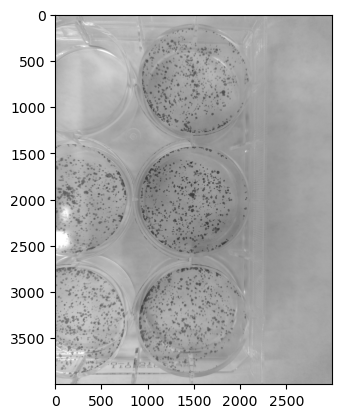

In [193]:
# open image color and grayscale
image = cv.imread("/home/frederico/dados/clonogenic/IMG_20231215_102920335.jpg")
image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

plt.imshow(image_gray, cmap="gray")
plt.show()

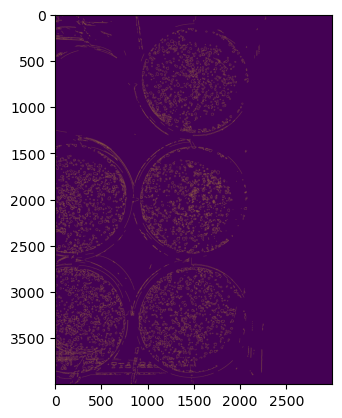

In [194]:
# detect edges
edges = ski.feature.canny(image_gray, sigma=1)
plt.imshow(edges)
plt.show()

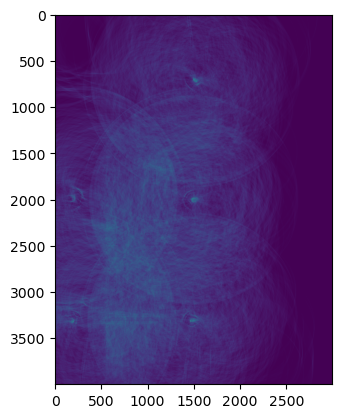

In [195]:
# detect circles
radius = [555]
hough_res = ski.transform.hough_circle(edges, radius)

plt.imshow(hough_res[0])
plt.show()

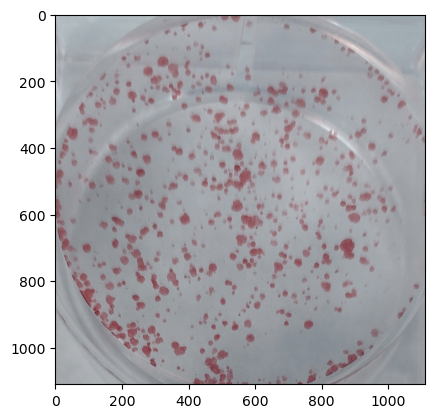

3


In [196]:
accum, cx, cy, radii = ski.transform.hough_circle_peaks(hough_res, radius, min_xdistance=radius[0], min_ydistance=radius[0])

x, y = image.shape[1], image.shape[0]

circles = [{"cx": x[0], "cy": x[1], "radii": x[2]} for x in zip(cx, cy, radii)]
circles = list(filter(lambda c: c["cx"] - c["radii"] > 0 and c["cx"] + c["radii"] < x and c["cy"] - c["radii"] > 0 and c["cy"] + c["radii"] < y, circles))

x_plots = 3 if len(circles) > 3 else len(circles)
y_plots = len(circles) // 3 + (1 if len(circles) % 3 > 0 else 0)

for circle in circles:
    plt.imshow(image[circle["cy"] - circle["radii"]:circle["cy"] + circle["radii"], circle["cx"] - circle["radii"]:circle["cx"] + circle["radii"]], cmap="gray")
plt.show()
print(len(circles))

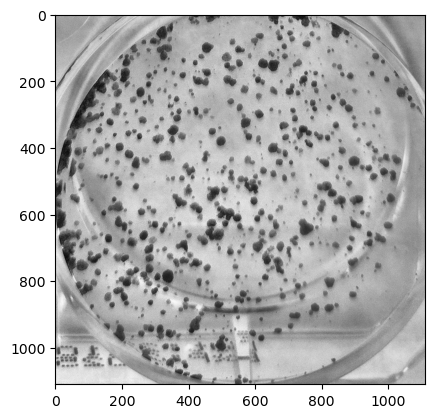

In [197]:
circle = circles[0]
well_image = image[circle["cy"] - circle["radii"]:circle["cy"] + circle["radii"], circle["cx"] - circle["radii"]:circle["cx"] + circle["radii"]]

clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(10, 10))
cl1 = clahe.apply(well_image[:, :, 2])

plt.imshow(cl1, cmap="gray")
plt.show()

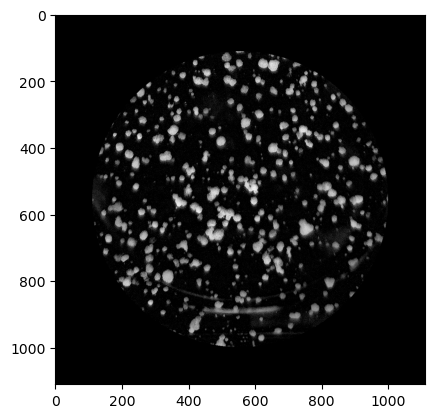

In [198]:
seed = np.copy(-cl1)
seed[1:-1, 1:-1] = (-cl1).min()
mask = -cl1

dilated = ski.morphology.reconstruction(seed, mask, method='dilation')

colonies = -cl1 - dilated

rows, cols = colonies.shape
cy, cx = rows // 2, cols // 2
Y, X = np.ogrid[:rows, :cols]
circle_mask = (X - cx)**2 + (Y - cy)**2 <= (radius[0] * 0.8)**2

masked_colonies = np.where(circle_mask, colonies, 0)

plt.imshow(masked_colonies, cmap="gray")
plt.show()

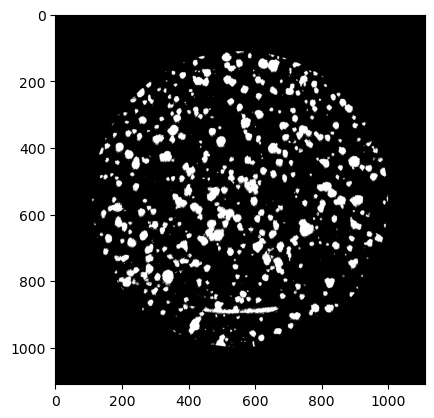

In [199]:
image = masked_colonies
thresh = ski.filters.threshold_otsu(masked_colonies)
binary = masked_colonies > thresh

plt.imshow(binary, cmap="gray")
plt.show()

/tmp/ipykernel_45035/631909101.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('prism', np.max(labels) + 1 if np.max(labels) > 0 else 2)


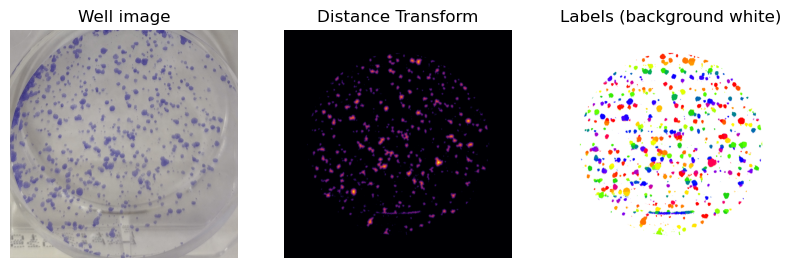

In [200]:
distance = sp.ndimage.distance_transform_edt(binary)
coords = ski.feature.peak_local_max(distance, footprint=np.ones((3, 3)), labels=binary)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = sp.ndimage.label(mask)
labels = ski.segmentation.watershed(-distance, markers, mask=binary)

cmap = plt.cm.get_cmap('prism', np.max(labels) + 1 if np.max(labels) > 0 else 2)
norm = np.max(labels) if np.max(labels) > 0 else 1

# map labels to RGBA and force background (label 0) to white
colored = cmap(labels / norm)
colored[labels == 0] = (1.0, 1.0, 1.0, 1.0)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(well_image[..., ::-1])  # convert BGR->RGB for correct display
ax[0].set_title('Well image')
ax[0].axis('off')

ax[1].imshow(distance, cmap='inferno')
ax[1].set_title('Distance Transform')
ax[1].axis('off')

ax[2].imshow(colored)
ax[2].set_title('Labels (background white)')
ax[2].axis('off')

plt.show()